# **Use Rigetti Aspen-9 QPU Calibration Specs in Noise Channel Parameters**

In this tutorial we will show you how to obtain the Rigetti Aspen-9 QPU calibration data and navigate its structure. We will also show how to use this data in a simple noise model using Amazon Braket's pre-defined noise channels. Knowing how to obtain and use this calibration data will help you create more realistic noise models for the Rigetti Aspen-9 QPU, giving you a better understanding on how your algorithms will behave on the real device.

We will begin by creating a noiseless circuit to prepare a GHZ state. We will then run the circuit on the local simulator and on the Rigetti Aspen-9 QPU to compare the results between the noiseless simulation and the real quantum device. Finally, we will simulate the same circuit with a simple noise model using the Rigetti Aspen-9 QPU calibration data. 

**Before you begin:** If you are new to Amazon Braket, we recommend you go over our [Getting Started](https://github.com/aws/amazon-braket-examples/tree/main/examples/getting_started) notebook series. These tutorials will show you how to create and run circuits on Amazon Braket's local simulators, high-performance mananged simulators, and QPU devices. Additionally, you should familiarize yourself with the basic noise concepts in the [Simulating Noise on Amazon Braket](https://github.com/aws/amazon-braket-examples/blob/main/examples/braket_features/Simulating_Noise_On_Amazon_Braket.ipynb) notebook from the [Amazon Braket Features](https://github.com/aws/amazon-braket-examples/tree/main/examples/braket_features) notebook series. The Braket Features series also goes over how to get devices and device properties, and how to specify which qubits you want your quantum algorithm to run on with the Rigetti Aspen-9 QPU.

## **Content**
* [Setup](#setup) 
* [Define a noiseless circuit to run on the Local Simulator](#noiseless)
* [Define a Circuit to Prepare a GHZ State on the real device](#qpu)
* [How to get the Rigetti Aspen-9 calibration data](#calibration)
    * [Get the AWS device](#dev)
    * [Get the calibration data](#get_data)
    * [Split the calibration data's nested dictionaries](#split)
* [Use the Rigetti Aspen-9 calibration data in a noisy circuit](#noisy_sim)

## **Setup** <a class="anchor" id="setup"></a>

### 1. General imports

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import string
import time
import math
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable, Noise
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

### 2. Add an S3 bucket and prefix

To use the Rigetti Aspen-9 QPU, or any other ``AWSDevice``, you need to specify the S3 location where your results will be stored. If you are only working with the local simulator ``LocalSimulator()`` you do not need to do this step.

In [167]:
# Please enter the S3 bucket created for Amazon Braket
# (or any other S3 bucket starting with 'amazon-braket-' in your account) in the code below
my_bucket = "amazon-braket-Your-Bucket-Name"
# the name of the folder in the bucket where the task results will be stored
my_prefix = "rigetti_noise_tutorial"

s3_folder = (my_bucket, my_prefix)

<div class="alert alert-block alert-info"> <b>Note: </b>Replace "Your-Bucket-Name" with your desired S3 bucket. Remember that bucket names for Amazon Braket always begin with "amazon-braket-".</div>

## **Define a noiseless circuit to run on the Local Simulator** <a class="anchor" id="noiseless"></a>

The next two sections will show you how the same circuit behaves in a noisless simulation and on a QPU device. Let's start by defining a circuit to prepare a 4-qubit [GHZ state](https://github.com/aws/amazon-braket-examples/blob/main/examples/getting_started/1_Running_quantum_circuits_on_simulators.ipynb).

In [8]:
def noiseless_ghz(n_qubits):
    """"
    Function to return a GHZ circuit ansatz
    input: number of qubits
    """
    
    circuit = Circuit()
    circuit.h(0)
    
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)
 
    return circuit

Create the circuit and print its diagram.

In [9]:
n_qubits = 4
noiseless_ghz = noiseless_ghz(n_qubits)
print(noiseless_ghz)

T  : |0|1|2|3|
              
q0 : -H-C-----
        |     
q1 : ---X-C---
          |   
q2 : -----X-C-
            | 
q3 : -------X-

T  : |0|1|2|3|


Use the local simulator to run the circuit. 

In [10]:
# define a local SV simulator
sv_device = LocalSimulator()
# run circuit
noiseless_result = sv_device.run(noiseless_ghz, shots=1000).result()
# get measurement shots
noiseless_counts = noiseless_result.measurement_counts
# print counts
print(noiseless_counts)

Counter({'1111': 502, '0000': 498})


Now you can plot the result.

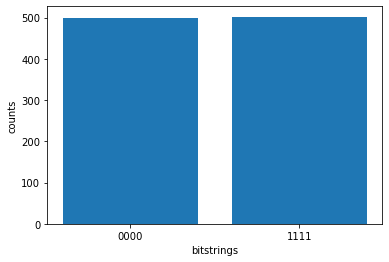

In [11]:
# plot using Counter
plt.bar(noiseless_counts.keys(), noiseless_counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

We can see the expected result for the noiseless GHZ state where we are only measuring $\left|1111\right\rangle$ and $\left|0000\right\rangle$ with an equal probability. Now let's see how circuit behaves on the real device.

## **Define a circuit to prepare a GHZ state on the real device** <a class="anchor" id="qpu"></a>

For this tutorial we will be hard-coding the qubits used to run the circuit on the Aspen-9 QPU. This will make it easier to map the calibration data in the "noisy" simulation later on. We chose four adjacent qubits ``[2,3,4,5]``. You can find the device topology through the  ``Devices`` tab in the [Amazon Braket console](https://console.aws.amazon.com/braket/home?region=us-east-1#/devices), then choosing the ``Rigetti - Aspen-9`` device. This is what it should look like.  

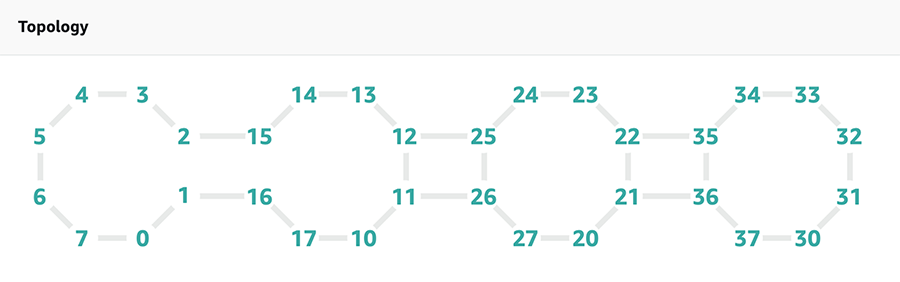

Now that we have our qubit indices we can begin building the circuit.

In [222]:
# This function builds a GHZ state
def ghz_circuit(n_qubits):
    """"
    Function to return a GHZ circuit ansatz
    input: number of qubits
    """
    
    circuit = Circuit()
    # the 4 static qubits
    qubit_indices = [2, 3, 4, 5]
    circuit.h(qubit_indices[0])
    
    for ii in range(0, n_qubits-1):
        circuit.cnot(control = qubit_indices[ii], target = qubit_indices[ii+1])
        
    return circuit

In [223]:
# define circuit
n_qubits = 4
ghz = ghz_circuit(n_qubits)

In [224]:
# print circuit
print(ghz)

T  : |0|1|2|3|
              
q2 : -H-C-----
        |     
q3 : ---X-C---
          |   
q4 : -----X-C-
            | 
q5 : -------X-

T  : |0|1|2|3|


Now get the Rigetti Aspen-9 device.

In [314]:
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-9")

Since we are hard-coding qubit assignments for this tutorial, you will need to set the ``disable_qubit_rewiring`` flag to True.

In [ ]:
# run the circuit on the real device
result = rigetti.run(ghz, shots=1000, s3_destination_folder=s3_folder, disable_qubit_rewiring=True).result()

Now you can run the circuit and print out its results.

In [226]:
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'0000': 237, '1111': 164, '0001': 116, '0111': 63, '1101': 59, '0101': 53, '0100': 50, '0011': 46, '1000': 42, '1100': 31, '1110': 30, '1011': 29, '1001': 29, '0110': 28, '0010': 16, '1010': 7})


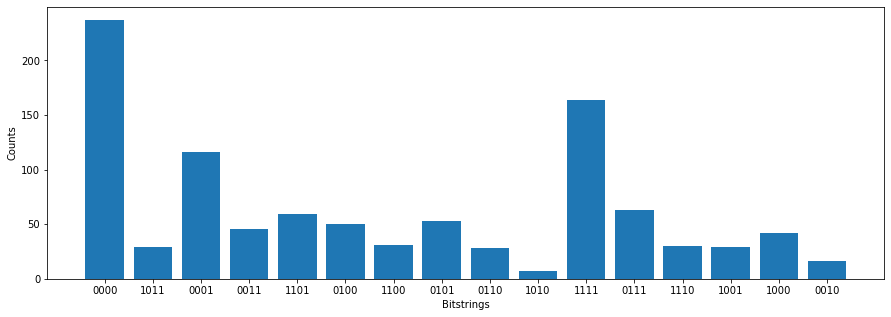

In [306]:
# plot real device using Counter
device_graph = plt.figure(figsize=(15,5))
device_graph = device_graph.add_subplot(1,1,1)
device_graph.bar(counts.keys(), counts.values())
plt.xlabel('Bitstrings');
plt.ylabel('Counts');

This result shows how noisy the real device is compared to the noiseless simulation. Real quantum devices are suceptible to noise such as errors during gate execution or a system's unwanted interaction with its evironment. In a perfect state we would only be expecting to measure an equal distribution for $\left|1111\right\rangle$ and $\left|0000\right\rangle$. The additional measurements in this graph are due to the noise experienced by the Rigetti Aspen-9 QPU during computation. It is important to take noise into account when simulating how quantum algorithms will behave on the real device. Now let's build and run a "noisy" version of the circuit that prepares a 4-qubit GHZ state.     

## **How to get the Rigetti Aspen-9 QPU device calibration data** 

In this section you will be shown how to obtain the Rigetti Aspen-9 device calibration data and how to separate it into two easy to work with dictionaries. After completing the next few steps, you will be able to use this data in a simple custom noise model for the Rigetti Aspen-9 superconducting quantum chip.  

### 1. Get the AWS device <a class="anchor" id="dev"></a>

If you did not run the GHZ circuit on the Rigetti device in the previous section, you can define the device using the Aspen-9 ARN as follows.

In [314]:
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-9")

### 2. Get the calibration data <a class="anchor" id="get_data"></a>

Now that you have created your AwsDevice with the Rigetti Aspen-9 ARN, you can get the calibration data using the following statement. 
```python
properties = rigetti.properties.dict()['provider']['specs']
```
This returns a nested dictionary holding both the 1-qubit (1Q) and 2-qubit (2Q) calibration data. 1Q contains a dictionary for each qubit on the device, 2Q contains one for each qubit pair. Finally, each one of these single qubit and qubit pairs contains a dictionary with the calibration data type and its values. This nested structure is shown in the diagram below.

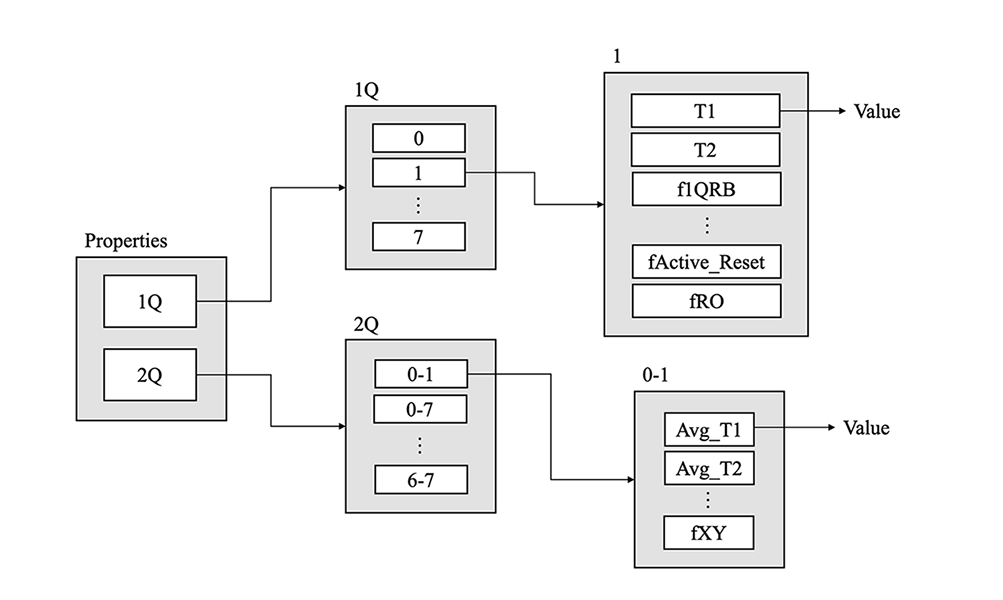

### 3. Split the calibration data's nested dictionaries <a class="anchor" id="split"></a>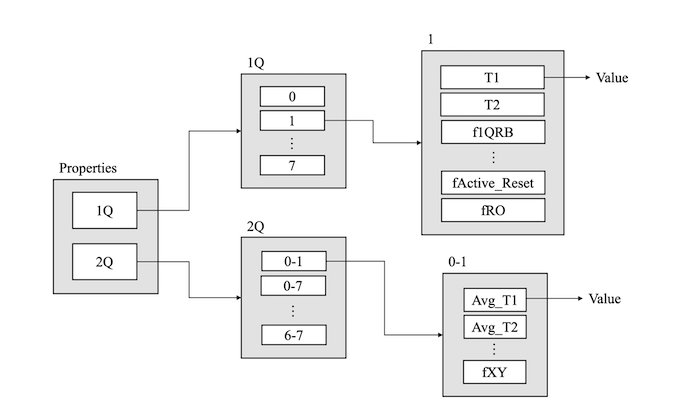

Now that you know more about the structure of the calibration data, let's extract '1Q' and '2Q' into two separate dictionaries, ``spec_1q`` and ``spec_2q``.  

**Single qubit calibration data (1Q)**

Let's start with the single qubit data. The following table gives a list of available 1-qubit calibration data types and their measurment units, as well as the keys necessary to extract the value. 

<table style="width:90%;text-align:left;">
  <tr>
    <th style="width:20%;">1 Qubit specs</th>
    <th style="text-align:left;">Description</th> 
    <th style="width:17%;">Key</th>
  </tr>
  <tr>
    <td>T1 (μs)</td>
    <td style="text-align:left;">Known as the energy relaxation, it is the time scale for a |1⟩ state to decay toward the ground state |0⟩.</td> 
    <td>"T1"</td>
  </tr>
  <tr>
    <td>T2 (μs)</td>
    <td style="text-align:left;">Known as dephasing time, it is the time scale for a |+⟩ state to decohere into the completely mixed state.</td> 
    <td>"T2"</td>
  </tr>
     <tr>
    <td>Fidelity (RB) (%)</td>
    <td style="text-align:left;">Single-qubit randomized benchmarking fidelities (for individual gate operation, normalized to unity).</td> 
    <td>"f1QRB"</td>
  </tr>
     <tr>
    <td>Fidelity (simultaneous RB) (%)</td>
    <td style="text-align:left;">Single-qubit randomized benchmarking fidelities (for simultaneous gate operation across the chip, normalized to unity).</td> 
    <td>"f1Q_simultaneous_RB"</td>
  </tr>
     <tr>
    <td>Active reset fidelity (%)</td>
    <td style="text-align:left;">Single-qubit active reset fidelities (normalized to unity).</td> 
    <td>"fActiveReset"</td>
  </tr>
     <tr>
    <td>Readout fidelity (%)</td>
    <td style="text-align:left;">Single-qubit readout fidelities (normalized to unity).</td> 
    <td>"fRO"</td>
</table>

You can use the folowing statement to extract the 1Q dictionary to ``spec_1q``. 

In [315]:
spec_1q = rigetti.properties.dict()['provider']['specs']['1Q']

Now print the keys of the ``speq_1Q`` dictionary.

In [334]:
print(spec_1q.keys())

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '20', '21', '22', '23', '24', '25', '26', '27', '3', '30', '31', '32', '33', '34', '35', '36', '37', '4', '5', '6', '7'])


Each key belongs to a qubit on the Rigetti Aspen-9 device. You can use these keys to obtain the calibration data for its corresponding qubit. Let's use qubit '1' as an example by printing the calibration data types available for it.

In [338]:
print(spec_1q['1'].keys())

dict_keys(['T1', 'T2', 'f1QRB', 'f1QRB_std_err', 'f1Q_simultaneous_RB', 'f1Q_simultaneous_RB_std_err', 'fActiveReset', 'fRO'])


Finally, print out qubit 1's T1 value.

In [359]:
print(spec_1q['1']['T1'])

3.541936599793516e-05


Great! Obtaining data from other qubits in the dictionary can be done by simply changing the first key value in the previous statement. The second key belongs to the calibration data type. Let's move on to extracting the 2Q dictionary. 

**Qubit pair calibration data (2Q)**

The following table gives a list of available 2-qubit calibration data and their measurment units as well as the keys necessary to extract the value.

<table style="width:90%;text-align:left;">
  <tr>
    <th style="width:21%;">2 Qubit specs</th>
    <th style="text-align:left;">Description</th> 
    <th style="width:17%;">Key</th>
  </tr>
  <tr>
    <td>Average T1 (μs)</td>
    <td style="text-align:left;">Known as the energy relaxation, it is the time scale for a |1⟩ state to decay toward the ground state |0⟩.</td> 
    <td>"Avg_T1"</td>
  </tr>
  <tr>
    <td>Average T2 (μs)</td>
    <td style="text-align:left;">Known as dephasing time, it is the time scale for a |+⟩ state to decohere into the completely mixed state.</td> 
    <td>"Avg_T2"</td>
  </tr>
     <tr>
    <td>Average Fidelity (RB) (%)</td>
    <td style="text-align:left;">Single-qubit randomized benchmarking fidelities (for individual gate operation, normalized to unity).</td> 
    <td>"Avg_f1QRB"</td>
  </tr>
     <tr>
    <td>Average Fidelity (simultaneous RB) (%)</td>
    <td style="text-align:left;">Single-qubit randomized benchmarking fidelities (for simultaneous gate operation across the chip, normalized to unity).</td> 
    <td>"Avg_f1Q_simultaneous_RB"</td>
  </tr>
  <tr>
    <td>Average Active reset fidelity (%)</td>
    <td style="text-align:left;">Single-qubit active reset fidelities (normalized to unity).</td> 
    <td>"Avg_fActiveReset"</td>
  </tr>
  <tr>
    <td>Average Readout fidelity (%)</td>
    <td style="text-align:left;">Single-qubit readout fidelities (normalized to unity).</td> 
    <td>"Avg_fRO"</td>
  </tr>
  <tr>
    <td>C-Phase gate fidelity (%)</td>
    <td style="text-align:left;">C-Phase gate fidelities (normalized to unity) for the qubit pair.</td> 
    <td>"fCPHASE"</td>
  </tr>
  <tr>
    <td>XY gate fidelity (%)</td>
    <td style="text-align:left;">XY(π) gate fidelities (normalized to unity) for the qubit pair.</td> 
    <td>"fXY"</td>
  </tr>
  <tr>
    <td>CZ gate fidelity (%)</td>
    <td style="text-align:left;">CZ gate fidelities (normalized to unity) for the qubit pair.</td> 
    <td>"fCZ"</td>
  </tr>
</table>

You can extract 2Q to ``spec_2q`` the same way you did for 1Q.

In [317]:
spec_2q = rigetti.properties.dict()['provider']['specs']['2Q']

Now print the keys of the ``speq_2Q`` dictionary.

In [327]:
print(spec_2q.keys())

dict_keys(['0-1', '0-7', '1-16', '10-11', '10-17', '11-12', '11-26', '12-13', '12-25', '13-14', '14-15', '16-17', '2-15', '2-3', '20-21', '20-27', '21-22', '21-36', '22-23', '22-35', '23-24', '24-25', '25-26', '26-27', '3-4', '30-31', '30-37', '31-32', '32-33', '33-34', '34-35', '35-36', '36-37', '4-5', '5-6', '6-7'])


Each key belongs to a qubit pair on the Rigetti Aspen-9 device. Use these keys to obtain the calibration data for its corresponding qubit pair. Let's use the pair '0-1' as an example by printing the calibration data types available for it.

In [333]:
print(spec_2q['0-1'].keys())

dict_keys(['Avg_T1', 'Avg_T2', 'Avg_f1QRB', 'Avg_f1QRB_std_err', 'Avg_f1Q_simultaneous_RB', 'Avg_f1Q_simultaneous_RB_std_err', 'Avg_fActiveReset', 'Avg_fRO', 'fCPHASE', 'fCPHASE_std_err', 'fCZ', 'fCZ_std_err', 'fXY', 'fXY_std_err'])


Print out the average T1 time for the 0-1 qubit pair.

In [340]:
print(spec_2q['0-1']['Avg_T1'])

2.679913663417025e-05


Similar to the single qubit calibration dictionary ``spec_1q``, obtaining data for each qubit pair in ``spec_2q`` can be done by changing the first key value in the the previous statement. The second key belongs to the calibration data type.

## **Use the Rigetti Aspen-9 QPU calibration data in a noisy circuit** <a class="anchor" id="noisy_sim"></a>

Now that you know how to extract and use the calibration data, we can build a simple noise model for the Rigetti Aspen-9 using Amazon Braket's predefined noise channels. 
Each qubit will be subject to dephasing, amplitude damping, and bitflip readout noise. This is based on a simple noise model described in the [Rigetti pyquil documentation](https://pyquil-docs.rigetti.com/en/stable/noise.html). The list below shows how you can obtain the noise probabilities from the calibration data and the gate timings. 

- **Dephasing Probability:** $p = 0.5 \cdot (1 - e^{-(\frac{gate\_time}{T_2})})$

- **Damping Probability:**  $p = 1 - e^{-(\frac{gate\_time}{T_1})}$

- **Readout Bit Flip Probability:** $p = 1 - readout\_fidelity$

The gate times we will be using are the default timings provided by Rigetti in their [Aspen-9 dashboard](https://qcs.rigetti.com/qpus/).

In [374]:
gate_time_1_qubit: float = 60e-9    
gate_time_2_qubit: float = 160e-09

Define the qubit indices to map the calibration data to the qubits used on the real device. 

In [375]:
qubit_indices = [2, 3, 4, 5]

By now, you know how to use the calibration data to obtain the probabilities that will be used as arguments for the noise channels. Now let's construct the "noisy" circuit with the the following function.

In [376]:
def ghz_noisy_circuit(n_qubits, qubit_indices):
    """"
    Function to return a "noisy" GHZ circuit ansatz
    input: number of qubits
    """
    
    circuit = Circuit()
   
    circuit.h(0)
    
    # apply single qubit dephasing 
    t2 = spec_1q[str(qubit_indices[0])]['T2']
    dephasing_prob = (0.5 * (1 - math.exp(-(gate_time_1_qubit/t2))))
    circuit.phase_flip(target=0, probability=dephasing_prob)
     
    # apply single qubit amplitude damping
    t1 = spec_1q[str(qubit_indices[0])]['T1']
    damping_prob = (1 - math.exp(-(gate_time_1_qubit/t1)))
    circuit.amplitude_damping(target=0, gamma=damping_prob)
    
    # apply Bit Flip readout noise
    noise = Noise.BitFlip(1- (spec_1q[str(qubit_indices[0])]['fRO']))
    circuit.apply_readout_noise(noise, target_qubits=0)
    
    for ii in range(0, n_qubits-1):
        
        circuit.cnot(control=ii, target=ii+1)
        
        # apply 2-qubit dephasing
        # 1. Get the t2 timing and calculate the probability
        # 2. Calculate the dephasing probability
        # 3. Apply the noise channel
        t2 = spec_2q[str(qubit_indices[ii])+'-'+str(qubit_indices[ii+1])]['Avg_T2']
        dephasing_prob = (0.5 * (1 - math.exp(-(gate_time_2_qubit/t2))))
        circuit.two_qubit_dephasing(target1=ii, target2=ii+1, probability=dephasing_prob)
    
        # apply 2-qubit amplitude damping
        # 1. Start by getting qubit ii T1 timing
        # 2. Calculate the damping probability
        # 3. Apply the noise channel
        # 4. Repeat steps 1-3 for qubit ii+1
        t1 = spec_1q[str(qubit_indices[ii])]['T1']
        damping_prob = (1 - math.exp(-(gate_time_2_qubit/t1)))
        circuit.amplitude_damping(target=ii, gamma=damping_prob)
        # qubit ii+1
        t1 = spec_1q[str(qubit_indices[ii+1])]['T1']
        damping_prob = (1 - math.exp(-(gate_time_2_qubit/t1)))
        circuit.amplitude_damping(target=ii+1, gamma=damping_prob)
       
        # Apply Bit Flip readout noise
        # 1. Define the noise channel. For this simplified model you can use (1 - readout_fidelity) as the probability of the Bit Flip channel
        # 2. Apply the noise channel to the circuit
        noise = Noise.BitFlip(1- (spec_1q[str(qubit_indices[ii+1])]['fRO']))                
        circuit.apply_readout_noise(noise, target_qubits=ii+1)
 
    return circuit

Let's print the circuit diagram.

In [378]:
noisy_ghz = ghz_noisy_circuit(n_qubits,  qubit_indices)
print(noisy_ghz)

T  : |          0           |            1            |           2            |                     3                     |
                                                                                                                            
q0 : -H-PF(0.0056)-AD(0.002)-C-DEPH(0.0047)-AD(0.0061)--------------------------BF(0.053)-----------------------------------
                             | |                                                                                            
q1 : ------------------------X-DEPH(0.0047)-AD(0.0042)-C-DEPH(0.004)-AD(0.0042)-BF(0.056)-----------------------------------
                                                       | |                                                                  
q2 : --------------------------------------------------X-DEPH(0.004)-AD(0.0086)-C---------DEPH(0.0065)-AD(0.0086)-BF(0.029)-
                                                                                |         |                                 


Now set up the local simulator and run the circuit. In order to simulate a "noisy" circuit, you need to use a density matrix simulator. You can do this with the ``'braket_dm'`` argument in your ``LocalSimulator()`` definition.

In [364]:
# set up device: Local Density Matrix Simulator
dm_device = LocalSimulator('braket_dm')

In [365]:
# run circuit
noisy_result = dm_device.run(noisy_ghz, shots=1000).result()
# get measurement shots
noisy_counts = noisy_result.measurement_counts
# print counts
print(noisy_counts)

Counter({'1111': 421, '0000': 385, '0111': 35, '1000': 33, '1110': 25, '1101': 21, '0100': 20, '0010': 19, '1011': 15, '0001': 13, '1100': 6, '0011': 3, '0101': 2, '1001': 2})


Now that we have some results, let's plot and compare with the real device.

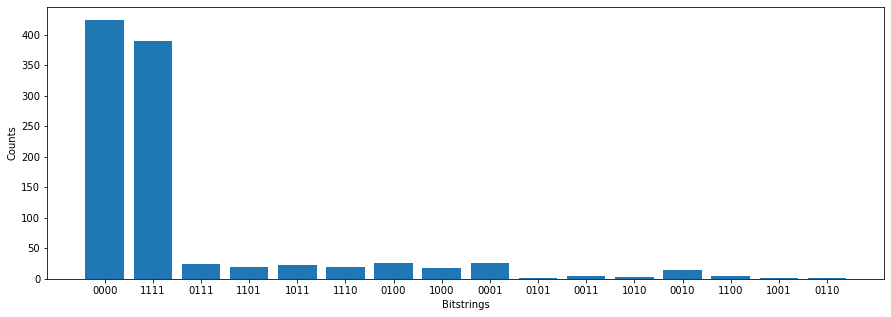

In [357]:
# plot using Counter
noise_sim_graph = plt.figure(figsize=(15,5))
bar_graph = noise_sim_graph.add_subplot(1,1,1)
bar_graph.bar(noisy_counts.keys(), noisy_counts.values())
plt.xlabel('Bitstrings');
plt.ylabel('Counts');

This result provided a more realistic distribution than the noiseless simulation. However, this model is not very accurate when compared with results from the real device. The counts, on average, are off by about a factor of two. One possible explanation for this is that by using the Amazon Braket predefined gates, we are not adding as much noise to the circuit as by building it from the bottom up with native gates supported by the Aspen-9. While exploring these posibilities is not in the scope of this tutorial, you now have the experience to use the Rigetti Aspen-9 calibration data in your own custom noise models. 